In [1]:
!pip install librosa tensorflow matplotlib scikit-learn tqdm


   ---------------------------------------- 0.0/260.1 kB ? eta -:--:--
   ---- ----------------------------------- 30.7/260.1 kB 1.3 MB/s eta 0:00:01
   ----------------- ---------------------- 112.6/260.1 kB 1.3 MB/s eta 0:00:01
   ----------------- ---------------------- 112.6/260.1 kB 1.3 MB/s eta 0:00:01
   ---------------------------------------- 260.1/260.1 kB 1.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/64.6 kB ? eta -:--:--
   ---------------------------------------- 64.6/64.6 kB ? eta 0:00:00
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---- ----------------------------------- 0.1/1.0 MB 3.0 MB/s eta 0:00:01
   ---------- ----------------------------- 0.3/1.0 MB 3.3 MB/s eta 0:00:01
   ----------------- ---------------------- 0.4/1.0 MB 3.4 MB/s eta 0:00:01
   ------------------- -------------------- 0.5/1.0 MB 3.1 MB/s eta 0:00:01
   ---------------------------- ----------- 0.7/1.0 MB 3.4 MB/s eta 0:00:01
   -----------------

In [3]:
# Import libraries
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm


In [5]:
# Set path to dataset
DATASET_PATH = "D:\INTERN\code alpha\ML dataset\RAVDESS_dataset"

# Emotions in RAVDESS dataset
EMOTIONS = {
    '01': 'neutral',
    '02': 'calm',
    '03': 'happy',
    '04': 'sad',
    '05': 'angry',
    '06': 'fearful',
    '07': 'disgust',
    '08': 'surprised'
}


<>:2: SyntaxWarning: invalid escape sequence '\I'
<>:2: SyntaxWarning: invalid escape sequence '\I'
C:\Users\sreep\AppData\Local\Temp\ipykernel_14340\3125488229.py:2: SyntaxWarning: invalid escape sequence '\I'
  DATASET_PATH = "D:\INTERN\code alpha\ML dataset\RAVDESS_dataset"


In [7]:
# Function to load and preprocess dataset
def load_data(dataset_path, emotions_to_include=None, n_mfcc=40):
    x_data, y_labels = [], []
    
    for root, dirs, files in os.walk(dataset_path):
        for file in tqdm(files):
            if file.endswith(".wav"):
                # Parse the emotion label from the filename
                parts = file.split('-')
                emotion = EMOTIONS[parts[2]]
                
                # Filter for specific emotions if required
                if emotions_to_include and emotion not in emotions_to_include:
                    continue
                
                # Load audio file
                file_path = os.path.join(root, file)
                audio, sample_rate = librosa.load(file_path, sr=None)
                
                # Extract MFCC features
                mfcc = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=n_mfcc)
                mfcc = np.mean(mfcc.T, axis=0)  # Take the mean along the time axis
                
                x_data.append(mfcc)
                y_labels.append(emotion)
    
    return np.array(x_data), np.array(y_labels)


In [9]:
# Load dataset
emotions_to_include = ['happy', 'sad', 'angry']
x, y = load_data(DATASET_PATH, emotions_to_include)


0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 138.87it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 118.40it/s]


In [22]:
# Encode labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Split into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y_categorical, test_size=0.2, random_state=42)

# Reshape data for CNN (add a channel dimension)
x_train = x_train[..., np.newaxis]  # Shape will be (num_samples, 40, 1, 1)
x_test = x_test[..., np.newaxis]    # Shape will be (num_samples, 40, 1, 1)

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer

# Build CNN model
model = Sequential([
    InputLayer(input_shape=(40, 1, 1)),  # Input shape with channel dimension
    Conv2D(32, kernel_size=(3, 1), activation='relu'),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.3),

    Conv2D(64, kernel_size=(3, 1), activation='relu'),
    MaxPooling2D(pool_size=(2, 1)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(y_train.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\sreep\anaconda3\Lib\site-packages\keras\src\layers\core\input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


In [26]:
# Train the model
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=30, batch_size=32)


Epoch 1/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.3250 - loss: 10.6961 - val_accuracy: 0.4199 - val_loss: 1.1457
Epoch 2/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3933 - loss: 3.2982 - val_accuracy: 0.4069 - val_loss: 1.0221
Epoch 3/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3709 - loss: 2.1995 - val_accuracy: 0.4069 - val_loss: 1.0663
Epoch 4/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3738 - loss: 1.6271 - val_accuracy: 0.4459 - val_loss: 1.0599
Epoch 5/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4192 - loss: 1.3249 - val_accuracy: 0.4892 - val_loss: 1.0607
Epoch 6/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3805 - loss: 1.1817 - val_accuracy: 0.4372 - val_loss: 1.0764
Epoch 7/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4544 - loss: 1.1474 - val_accuracy: 0.4502 - val_loss: 1.0680
Epoch 8/30
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4195 - loss: 1.0830 - val_accuracy: 0.5152 - val_los

In [28]:
# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.2f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7213 - loss: 0.6874 
Test Accuracy: 0.73


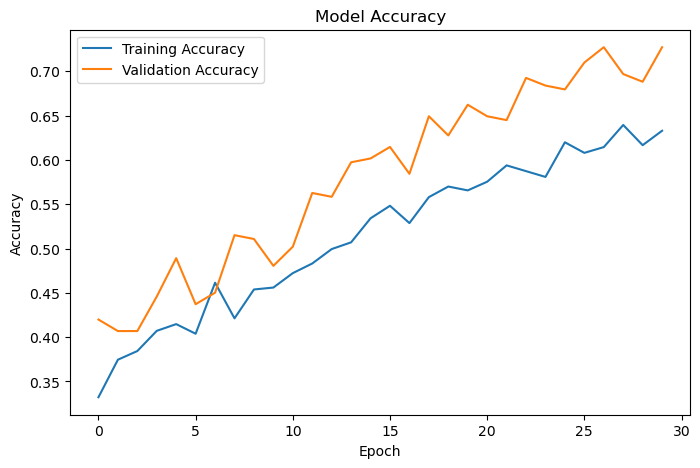

In [30]:
# Plot training and validation accuracy
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


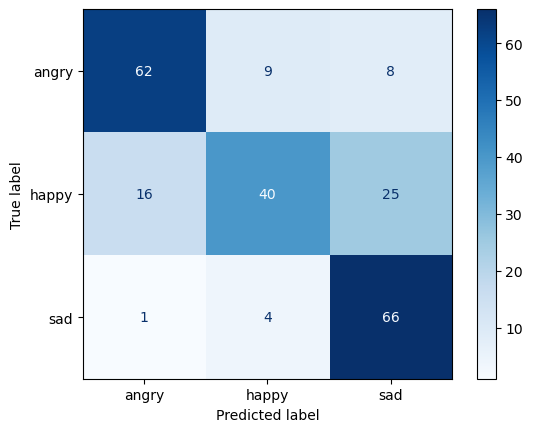

In [32]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

cm = confusion_matrix(y_true_classes, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=label_encoder.classes_)
cmd.plot(cmap=plt.cm.Blues)
plt.show()


In [35]:
model.save('emotion_recognition_model.h5')
print("Model saved as 'emotion_recognition_model.h5'")


Model saved as 'emotion_recognition_model.h5'


In [37]:
from tensorflow.keras.models import load_model

# Load model
model = load_model('emotion_recognition_model.h5')

# Print model summary to verify
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 38, 1, 32)           │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 19, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 19, 1, 32)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 17, 1, 64)           │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 8, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 8, 1, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          65,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 72,389 (282.77 KB)

 Trainable params: 72,387 (282.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)